# Individual ML project (Luigi Noto)

### Task description

This dataset is composed of 3920 samples with 6 features each. The first column
represents the sample id. The remaining columns are features. There are no
categorical features.

Your task is the following: you should find an optimal clustering of the data
using the k-Means algorithm (implemented by `sklearn.cluster.KMeans`). This
includes finding the best number of clusters. You need to decide whether or not
to scale the data (consider using the sklearn function
`preprocessing.minmax_scale`), whether or not to perform PCA, and in which order
to perform these operations, the optimal parameters for the algorithm etc. Once
you have found your optimal settings, make sure that they are specified in the
conclusions of your notebook, and also print the cluster label of each point in
a file.

The notebook will be evaluated not only based on the final results, but also on
the procedure employed, which should balance practical considerations with the
desire to achieve the best possible performance with high confidence.

Bonus points may be assigned for particularly clean/nifty code and/or well-
presented results.

## Table of contents
- [1. Setup and dataset import](#section1)
- [2. Preliminary analysis and data preprocessing](#section2)
- [3. Core analysis: finding the best number of clusters $k$](#section3)
  - [3.1 Elbow method with K-Means *inertia*](#section3.1)
  - [3.2 Silhouette analysis](#section3.2)
  - [3.3 *S_Dbw* validity index](#section3.3)
  - [3.4 *Davies-Bouldin (DB)* index](#section3.4)
  - [3.5 Storing optimal K-Means](#section3.5)
  - [3.6 Comparison with no scaling and with standardization](#section3.6)
- [4. Data visualization on the first 2 and 3 principal components](#section4)
  - [4.1 Dimensionality reduction to 2D and clustering visualization with $k$ = 14](#section4.1)
  - [4.2 Dimensionality reduction to 3D and clustering visualization with $k$ = 14](#section4.2)
- [5. Label print](#section5)
- [6. Conclusions](#section6)

## <a name="section1"></a>1. Setup and dataset import

I upload some libraries that are essential for the analysis. The `s_dbw` library can be downloaded [here](https://pypi.org/project/s-dbw/) (See [3.3 *S_Dbw* validity index](#section3.3)).

In [127]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import FixedLocator, FixedFormatter

from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from s_dbw import S_Dbw
from sklearn.metrics import davies_bouldin_score

I load the dataset in a single pandas `DataFrame` object, since the data are not labeled.

In [99]:
path = os.getcwd()

def load_data(data_path=path):
    csv_path = data_path + "/mldata_0013075187.csv"
    return pd.read_csv(csv_path)

In [100]:
data = load_data()
data.head()

,Unnamed: 0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,0,0.261178,0.137158,0.525661,0.402121,3.259105,0.082827
1,1,1.685689,1.183334,0.159572,0.478285,-0.000125,4.489681
2,2,1.196424,0.784589,0.167710,0.957283,0.886082,4.290275
3,3,0.069293,0.054746,0.567886,0.153321,3.041086,0.004999
4,4,0.096378,0.061049,0.558682,0.155299,3.053612,0.005657


The first column representing the sample id is not relevant to the analysis, because it does not provide relevant information, therefore I drop it from the `DataFrame` object.

In [101]:
X = data.drop(columns = "Unnamed: 0")
X.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,0.261178,0.137158,0.525661,0.402121,3.259105,0.082827
1,1.685689,1.183334,0.159572,0.478285,-0.000125,4.489681
2,1.196424,0.784589,0.167710,0.957283,0.886082,4.290275
3,0.069293,0.054746,0.567886,0.153321,3.041086,0.004999
4,0.096378,0.061049,0.558682,0.155299,3.053612,0.005657


## <a name="section2"></a>2. Preliminary analysis and data preprocessing

I get a quick description of the data.

In [102]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3920 entries, 0 to 3919
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  3920 non-null   float64
 1   feature_2  3920 non-null   float64
 2   feature_3  3920 non-null   float64
 3   feature_4  3920 non-null   float64
 4   feature_5  3920 non-null   float64
 5   feature_6  3920 non-null   float64
dtypes: float64(6)
memory usage: 183.9 KB


Each feature has 3920 non-null values, which means that there are no missing values. This is very important, because the K-Means algorithm cannot handle missing values, and therefore if there had been missing values, it would have been necessary to take that into account, by eliminating either some features or some instances, or by filling the missing values in some way, thereby potentially affecting the information in the dataset and biasing the analysis.
Moreover, as already stated in the task description, all the features are numeric. I get a summary of each of them.

In [103]:
X.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
count,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000
mean,0.778400,0.545842,0.259694,0.409617,1.624276,2.144324
std,0.698407,0.360161,0.165416,0.262041,0.946827,1.762585
min,-0.006020,-0.073347,-0.011441,-0.074013,-0.030017,-0.020687
25%,0.082988,0.168787,0.148245,0.187230,0.873589,0.602328
50%,0.719666,0.587081,0.269312,0.378044,1.826279,1.957537
75%,1.489350,0.779234,0.330930,0.586409,2.222612,3.786263
max,1.698846,1.223463,0.582687,0.996177,3.272361,5.022102


From the above summary, it can be noticed that the features take values in different ranges, by looking at the `min` and `max` rows, and by looking at the percentiles `25%`, `50%` and `75%` rows. This can be noticed also by plotting the histograms.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a28227668>,
      dtype=object)

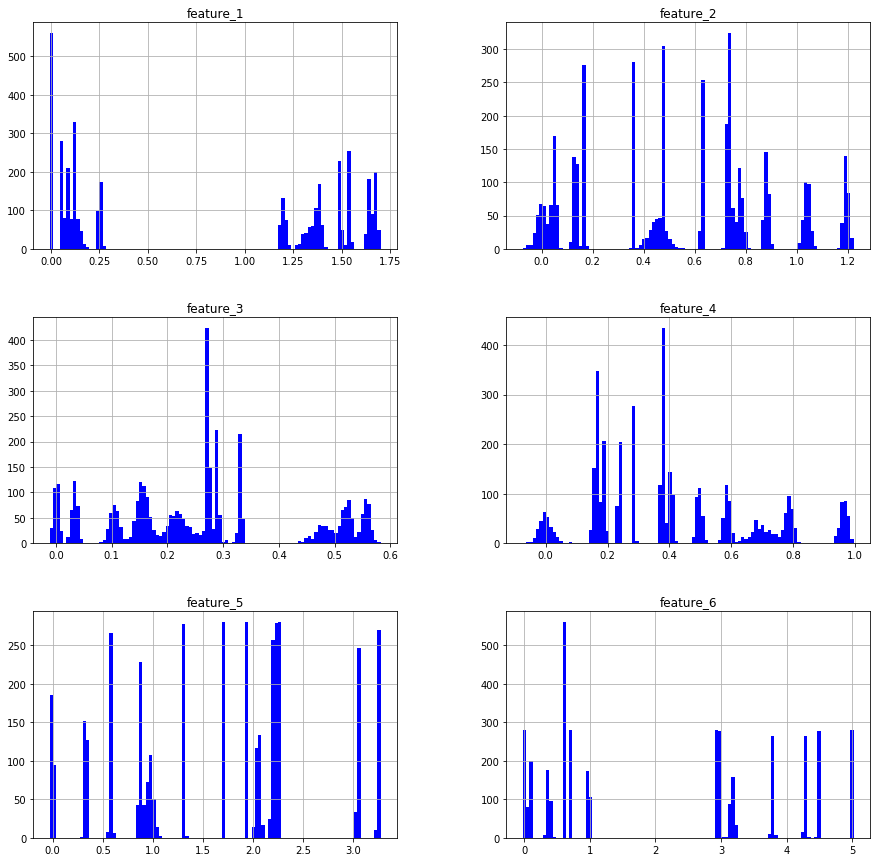

In [104]:
X.hist(bins=100, figsize=(15,15), color = "blue")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a289ca0b8>,
      dtype=object)

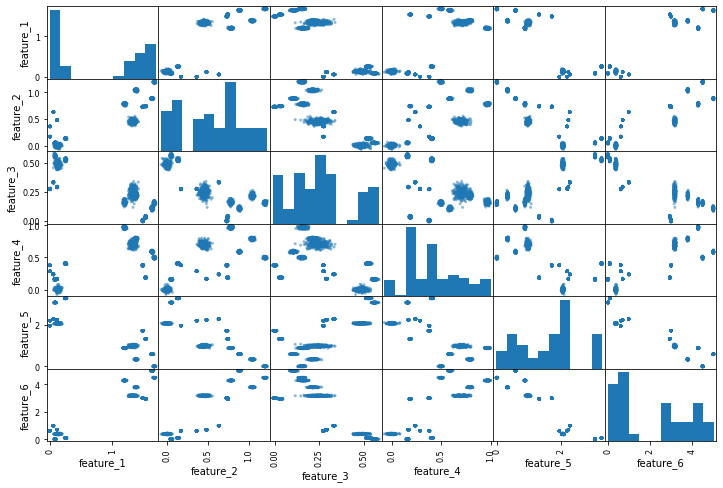

In [105]:
scatter_matrix(X, figsize=(12,8))

In [106]:
corr_matrix = X.corr()
corr_matrix

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
feature_1,1.000000,0.803521,-0.770117,0.587975,-0.827286,0.936483
feature_2,0.803521,1.000000,-0.764894,0.561866,-0.843103,0.872266
feature_3,-0.770117,-0.764894,1.000000,-0.402660,0.708239,-0.769368
feature_4,0.587975,0.561866,-0.402660,1.000000,-0.641429,0.722328
feature_5,-0.827286,-0.843103,0.708239,-0.641429,1.000000,-0.920190
feature_6,0.936483,0.872266,-0.769368,0.722328,-0.920190,1.000000


By looking at the correlation matrix, I can see that some pairs of features are highly correlated, e.g. `feature_1` and `feature_2`, or `feature_1` and `feature_6`. Moreover, no pair of features has correlation lower than 0.4 in absolute value. This potentially suggests that there might be some unnecessary details in the dataset, meaning that most of the information might actually lie on some lower-dimensional subspace.

Since K-Means is a distance-based algorithm, which is based on distance comparisons and uses the Euclidean distance, and some features in the dataset might have different scales, it is important to scale the features, i.e. by applying min-max scaling as suggested in the task description, performed by the function `sklearn.preprocessing.minmax_scale`, assuming that I want all the features to be treated with approximately the same importance.
In fact, if the data were not scaled, some features would dominate on others in the distance comparison and therefore they would be treated as more important. 
In general, by scaling the features, stretched, non-spherical clusters can potentially assume nice and more spherical shapes, thereby reducing the risk that K-Means will perform poorly.

Moreover, as stated before, the high correlation between some features might indicate that the samples lie within (or close to) a lower-dimensional subspace. Thus, performing PCA might be beneficial for the analysis, since most of the variance is likely to be explained by some of all the principal components. In this case, reducing the dimensionality of the data might filter out some noise and unnecessary details.

Although the dataset consists of 3920 samples per 6 features, which is not a high-dimensional dataset, and therefore it is reasonable that the K-Means algorithm would not incur into the so-called *curse of dimensionality* issue, I opt to scale the features and then performing PCA to check whether there are principal components that do not contribute to the variance, since they will most certainly not be useful for clustering.

In [107]:
X_tr = minmax_scale(X)

In [108]:
X_trdf = pd.DataFrame(X_tr, columns=["feature_1","feature_2","feature_3","feature_4","feature_5","feature_6"])

In [109]:
X_trdf.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
count,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000
mean,0.460107,0.477471,0.456359,0.451910,0.500940,0.429328
std,0.409655,0.277728,0.278419,0.244855,0.286711,0.349526
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.052208,0.186715,0.268775,0.244109,0.273623,0.123546
50%,0.425656,0.509271,0.472547,0.422408,0.562109,0.392288
75%,0.877119,0.657445,0.576258,0.617107,0.682123,0.754930
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [110]:
X_trdf.corr()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
feature_1,1.000000,0.803521,-0.770117,0.587975,-0.827286,0.936483
feature_2,0.803521,1.000000,-0.764894,0.561866,-0.843103,0.872266
feature_3,-0.770117,-0.764894,1.000000,-0.402660,0.708239,-0.769368
feature_4,0.587975,0.561866,-0.402660,1.000000,-0.641429,0.722328
feature_5,-0.827286,-0.843103,0.708239,-0.641429,1.000000,-0.920190
feature_6,0.936483,0.872266,-0.769368,0.722328,-0.920190,1.000000


From the above table, I can verify that every feature takes values in the interval $[0, 1]$, as expected. Moreover, I can also notice that the normalized features have more similar standard deviations: this confirms the fact that the non-normalized features are likely to be measured in different scales and also implies that in this case min-max scaling is likely to be beneficial also for the performance of PCA in identifying the directions that contain most of the information. Thus, normalizing the features must have been a good choice, because, looking at the scaled dataset, it can potentially improve the performance of both K-Means and PCA.

Thus, I apply PCA on the scaled dataset to identify all the principal components and check whether there are components that do not contribute to the variance.
I do not explicitly zero-center the datapoints, since this step is already performed when fitting the `sklearn.decomposition.PCA` object to the data.

In [111]:
pca = PCA()
pca.fit(X_tr)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

(1, 6)

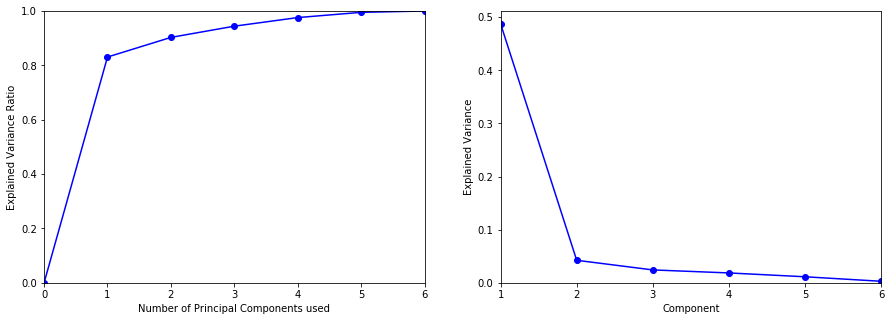

In [112]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
exp_var = np.zeros(len(pca.explained_variance_ratio_)+1)
exp_var[1:] = pca.explained_variance_ratio_
plt.plot(range(len(pca.explained_variance_ratio_)+1), np.cumsum(exp_var), "bo-")
plt.xlabel("Number of Principal Components used")
plt.ylabel("Explained Variance Ratio")
plt.ylim([0,1])
plt.xlim([0,6])

plt.subplot(122)
plt.plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_, "bo-")
plt.xlabel("Component")
plt.ylabel("Explained Variance")
plt.ylim(ymin=0)
plt.xlim([1, 6])

The first graph represents the *explained variance ratio* (proportion of the dataset's variance) as a function of the number of principal components used. The second graph plots the variance explained by each principal component. I can see that the 6-th principal component basically do not contribute to the variance at all, therefore it is very likely that it is not relevant for the cluster analysis and that reducing the dataset to the first 5 principal components might even filter out some noise. Thus, I reduce the dataset to the subspace defined by the first 5 principal components to carry out the cluster analysis for finding the best number of clusters.

In [113]:
pca5d = PCA(n_components=5)
X_tr5d = pca5d.fit_transform(X_tr)
X_tr5d

array([[-8.23058486e-01, -2.01377628e-01,  2.12758211e-01,
        -7.04859380e-02, -1.86879057e-01],
       [ 9.62908847e-01,  4.90271171e-02, -4.79970059e-02,
         2.86540654e-01, -3.34131241e-02],
       [ 6.73904342e-01, -3.48454539e-01, -7.16224837e-02,
        -1.60636331e-01, -2.30505142e-03],
       ...,
       [ 4.98745523e-01,  3.27066399e-01,  1.05952520e-01,
        -2.09543065e-01, -7.24416734e-02],
       [-9.63758410e-01, -8.74744677e-02,  1.99606449e-01,
         7.42352625e-02, -7.27003933e-02],
       [ 9.04476542e-01, -7.99508471e-04,  6.43283012e-02,
         1.34561412e-02,  3.78781444e-02]])

## <a name="section3"></a>3. Core analysis: finding the best number of clusters $k$

Since I have unlabeled data, I have no prior information about what a reasonable, meaningful number of clusters could be for the provided dataset. Moreover, one downside of the K-Means algorithm is that it requires the number of clusters it has to look for as input. Thus, I cannot use any *external clustering validation criterion*, such as `sklearn.metrics.homogeneity_score`, based on a measure of agreement between two partitions where the first partition is the a priori known clustering structure and the second results from the clustering procedure, but I can only use *internal clustering validation criteria*, measuring the goodness of clustering without external information, and based on the idea that a good clustering achieves high "cohesion" of each cluster and high "separation" among clusters.
In other words, the more dense are groups inside and the less is density outside them (or the more distant groups draw apart) the higher is internal validity. Different *internal clustering validation criteria*, depending on their formula, differently realize and accentuate this intuitive principle when testing internal clustering validity.

Thus, I run the K-Means algorithm for different values of the `n_clusters` parameter (from $k$ = 1 to $k$ = 29) to carry out the cluster analysis. I leave the parameter `init` to its default value `"k-means++"`, because in this way the algorithm uses the K-Means++ centroid initialization which makes it less likely to converge to a sub-optimal solution. Moreover, I do not need to perform mini-batch K-means, since the dataset is relatively small and fits in memory.

In [114]:
kmeans_seq = [KMeans(n_clusters=k, random_state=42).fit(X_tr5d) for k in range(1, 30)]

### <a name="section3.1"></a>3.1 Elbow method with K-Means *inertia*

In order to find the best number of clusters, I inspect how the K-Means *inertia*, i.e. the mean squared distance between each instance and its closest centroid, varies with the number of clusters $k$ I give as input to the K-Means algorithm. Obviously, the more clusters there are, the closer each instance will be to its closest centroid and the lower will be the *inertia*. However, by analyzing how the *inertia* drops as the value of $k$ increases, it is possible to deduce what the optimal number of clusters is.

In [115]:
inertia_seq = [kmeans.inertia_ for kmeans in kmeans_seq]

[8, 19.25, 0, 20]

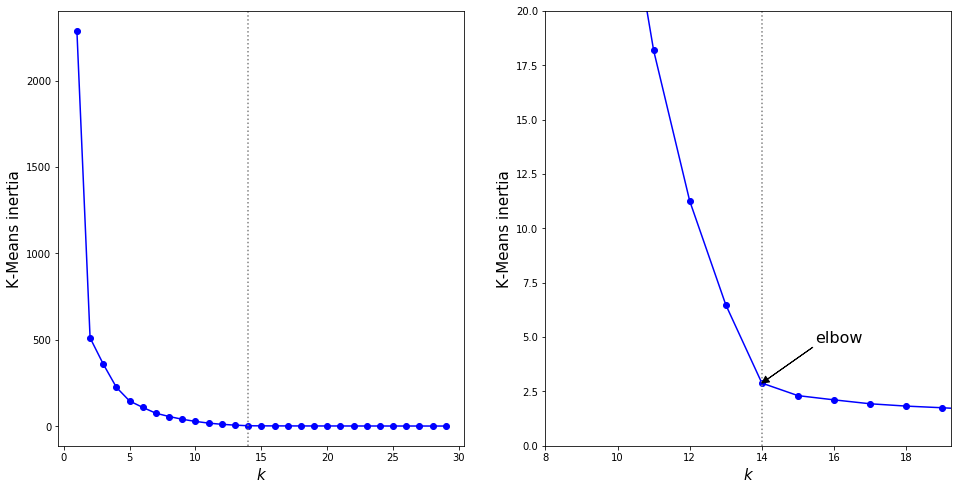

In [116]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.plot(range(1, 30), inertia_seq, "bo-")
plt.axvline(x = 14, color = 'grey', linestyle = ':', solid_capstyle='butt')
plt.xlabel("$k$", fontsize=15)
plt.ylabel("K-Means inertia", fontsize=15)

plt.subplot(122)
plt.plot(range(1, 30), inertia_seq, "bo-")
plt.axvline(x = 14, color = 'grey', linestyle = ':', solid_capstyle='butt')
plt.xlabel("$k$", fontsize=15)
plt.ylabel("K-Means inertia", fontsize=15)
plt.annotate('elbow', xy=(14, inertia_seq[13]), xytext=(0.85, 0.30), textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', width=0.1, headlength=7, headwidth=7)
            )
plt.axis([8, 19.25, 0, 20])

From the graph, it is not easy to see where the elbow is located in order to identify the best number of clusters.
On the other hand, by zooming the graph, I can notice that there is an *elbow* at $k$ = 14, meaning that the inertia drops relatively fast up to $k$ = 14 and for higher values of $k$ it decreases much more slowly. This suggests that $k$ = 14 might represent a good choice for the best number of clusters. However, before drawing any conclusions with this heuristic and coarse approach, it is better to adopt some more precise (even though more computationally expensive) techniques and check whether they provide the same answer.

### <a name="section3.2"></a>3.2 Silhouette analysis

This technique uses the so-called *silhouette score*, which is the mean of the *silhouette coefficient* over all the instances. An instance's *silhouette coefficient* is defined as 
$$\dfrac{(b-a)}{max(a, b)}$$
where $a$ is the mean intra-cluster distance (the mean distance to the other instances in the same cluster) and $b$ is the mean nearest-cluster distance (the mean distance to the instances of the next closest cluster, i.e. the closest cluster excluding the instance's own cluster), and varies between -1 and 1, where -1 indicates that the instance may be assigned to the wrong cluster and 1 indicates that the instance is perfectly inside its own cluster.
Thus, the *silhuoette score* is a good index to find the best number of clusters for many types of datasets. The optimal number of clusters is found when the index reatches its maximum.

The *silhouette score* is not defined for $k$ = 1.

In [117]:
silhouette_score_seq = [silhouette_score(X_tr5d, kmeans.labels_) for kmeans in kmeans_seq[1:]]

[1.5, 19.5, 0.5, 0.95]

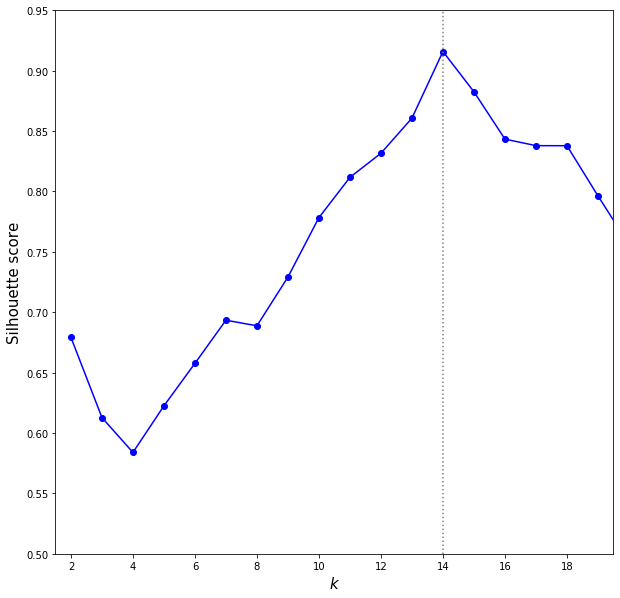

In [118]:
plt.figure(figsize=(10, 10))

plt.plot(range(2, 30), silhouette_score_seq, "bo-")
plt.axvline(x = 14, color = 'grey', linestyle = ':', solid_capstyle='butt')
plt.xlabel("$k$", fontsize=15)
plt.ylabel("Silhouette score", fontsize=15)
plt.axis([1.5, 19.5, 0.5, 0.95])

The above graph represents the *silhouette scores* for different values of $k$. I see that the highest *silhouette score* is achieved at $k$ = 14, meaning that when finding 14 clusters the instances are clustered better on average than when finding a different number of clusters.

Thus, *silhouette analysis* confirms what I deduced with the *elbow method*. Differently from the previous visualization, this visualization also reveals that the values from $k$ = 13 to $k$ = 18 might also be good choices (even though worse than $k$ = 14) but higher values of $k$ might not be very good choices, since the *silhouette score* starts dropping considerably as $k$ further increases.

I can also provide a more informative visualization, especially for the better values from $k$ = 13 to $k$ = 16, which is called *silhouette diagram* and plots each instance's *silhouette coefficient*, sorted by clustering assignment and value of the coefficient.

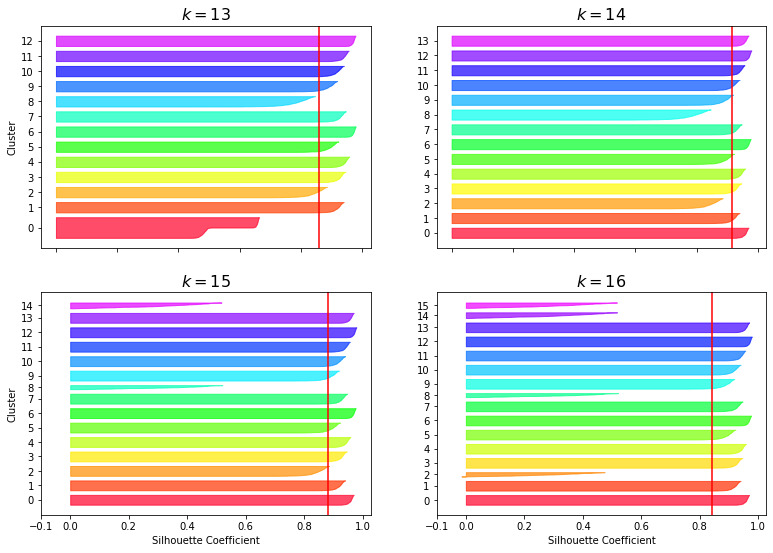

In [119]:
plt.figure(figsize=(13, 9))

for k in (13, 14, 15, 16):
    plt.subplot(2, 2, k - 12)

    silhouette_coefficients = silhouette_samples(X_tr5d, kmeans_seq[k-1].labels_)

    padding = len(X_tr5d) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[kmeans_seq[k-1].labels_ == i]
        coeffs.sort()

        cm = plt.get_cmap('gist_rainbow')
        color = cm(1.*i/k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (13, 15):
        plt.ylabel("Cluster")
    
    if k in (15, 16):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_score_seq[k - 2], color="red", linestyle="-")
    plt.title("$k={}$".format(k), fontsize=16)

The vertical red line in each graph represents the *silhouette score* for each clustering. When the instances of a cluster of a certain clustering have a much lower *silhouette coefficient* than the corresponding *silhouette score*, then the cluster might be bad according to how *silhouette analysis* realizes the intuitive principle of internal clustering validity, because this indicates that the instances of this cluster are too close to the instances of other clusters. From this visualization, it is clear that the case $k$ = 14 outperforms the other cases in terms of internal clustering validity. However, also $k$ = 14 seems to have some problems: the clusters are approximately of the same size (number of instances per cluster), but the instances in cluster 2 and 8 have lower *silhouette coefficients* than the *silhouette score*, even though by not too much. Since the *silhouette score* is very high, thereby indicating a very good clustering, this minor issue could be due to the fact that the *silhouette coefficient* has limitations in the case of clusters of different densities and in the presence of subclusters and if this is the case it might lose some expressive power when looking at the *silhouette diagram*, provided that K-Means succeded in identifying such clusters.

### <a name="section3.3"></a>3.3 *S_Dbw* validity index

Because of the observations in the previous paragraph, for the sake of completeness, I have decided to look for an internal clustering validation index that empirically has not shown limitations in datasets with subclusters and/or other characteristics and carry out the same analysis as before with such index, so that if I get the same optimal number of clusters, I can be reasonably sure that $k$ = 14 corresponds to the optimal clustering of the provided dataset.
I have found in *Understanding of Internal Clustering Validation Measures, 2010 IEEE International Conference on Data Mining* and other sources that the so-called *S_Dbw* index empirically proved to get the "right" number of clusters in the case of clusters of different densities, in the presence of subclusters and also other cases in which silhouette analysis either failed or lost some expressive power when looking at the *silhouette diagram*.

This index takes density instead of distance into account to measure cluster separation and is based on the idea that for each pair of cluster centers, at least one of their densities should be larger than the density of their midpoint.
It is defined as
$$S\_Dbw(C)=Scat(C)+Den(C)$$
where $Scat(C)$ and $Den(C)$ represent the within-cluster variance and the inter-cluster density, respectively. The optimal number of clusters is found when the index reaches its minimum.

Since Scikit-Learn does not contain a function for computing the *S_Dbw* validity index, I have installed a very simple library, whose documentation can be found [here](https://pypi.org/project/s-dbw/).

In [120]:
sdbw_seq = [S_Dbw(X_tr5d, kmeans.labels_) for kmeans in kmeans_seq[1:]]

[9, 25.5, 0, 0.1]

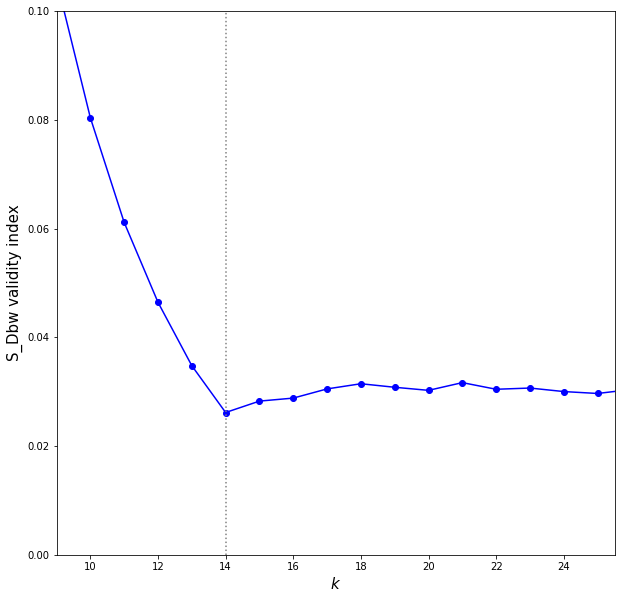

In [121]:
plt.figure(figsize=(10, 10))

plt.plot(range(2, 30), sdbw_seq, "bo-")
plt.axvline(x = 14, color = 'grey', linestyle = ':', solid_capstyle='butt')
plt.xlabel("$k$", fontsize=15)
plt.ylabel("S_Dbw validity index", fontsize=15)
plt.axis([9, 25.5, 0, 0.1])

The above graph represents the *S_Dbw* index for different values of $k$. Thus, the analysis with the *S_Dbw* index has confirmed my previous findings that the optimal number of clusters is $k$ = 14.

### <a name="section3.4"></a>3.4 *Davies-Bouldin (DB)* index

Another index with which I can carry out the same analysis is the *Davies-Bouldin (DB)* index, defined as
$$DB=\dfrac{1}{k}\sum_{i=1}^k \max_{i\neq j}\left(\dfrac{s_i+s_j}{d_{ij}}\right)$$
where
- $k$ is the number of clusters;
- $s_i$ is the average distance between each point of cluster $i$ and the centroid of that cluster;
- $d_{ij}$ is the distance between cluster centroids $i$ and $j$.

The optimal number of clusters is found when the index reaches its minimum.

In [122]:
db_seq = [davies_bouldin_score(X_tr5d, kmeans.labels_) for kmeans in kmeans_seq[1:]]

[9, 25.5, 0, 1]

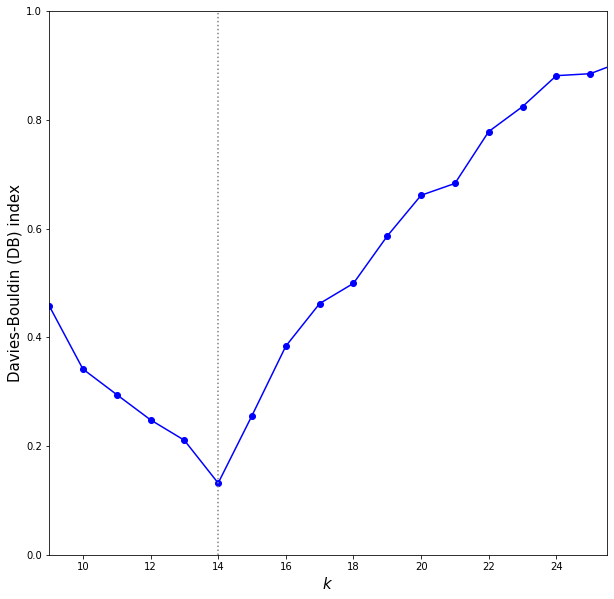

In [123]:
plt.figure(figsize=(10, 10))

plt.plot(range(2, 30), db_seq, "bo-")
plt.axvline(x = 14, color = 'grey', linestyle = ':', solid_capstyle='butt')
plt.xlabel("$k$", fontsize=15)
plt.ylabel("Davies-Bouldin (DB) index", fontsize=15)
plt.axis([9, 25.5, 0, 1])

The above graph represents the *Davies-Bouldin (DB)* index for different values of $k$. Also the analysis with the *Davies-Bouldin (DB)* index confirms that the optimal number of clusters is $k$ = 14.

### <a name="section3.5"></a>3.5 Storing optimal K-Means

The outcome of all the above internal clustering validation methods is that $k$ = 14 is the best number of clusters. Thus, I store the fitted K-Means with the optimal number of clusters $k$ = 14 in the variable `opt_kmeans`.

In [124]:
opt_kmeans = kmeans_seq[13]
opt_kmeans.labels_

array([ 3, 10,  5, ...,  4,  7,  1], dtype=int32)

### <a name="section3.6"></a>3.6 Comparison with no scaling and with standardization

I just want to see whether by not scaling the data or by standardizing the data I would have different outcomes in terms of the best number of clusters and the optimal clustering found. Thus, I carry out the previous analysis both with the data not scaled and with the subspace defined by the first 5 principal components of the standardized data.

In [125]:
def cluster_analysis(data, n2):
    kmeans_seq1 = [KMeans(n_clusters=k, random_state=42).fit(data) for k in range(1, n2)]
    silhouette_score_seq1 = [silhouette_score(data, kmeans.labels_) for kmeans in kmeans_seq1[1:]]
    sdbw_seq1 = [S_Dbw(data, kmeans.labels_) for kmeans in kmeans_seq1[1:]]
    db_seq1 = [davies_bouldin_score(data, kmeans.labels_) for kmeans in kmeans_seq1[1:]]
    
    silhouette_kmax = np.argmax(silhouette_score_seq1) + 2
    sdbw_kmin = np.argmin(sdbw_seq1) + 2
    db_kmin = np.argmin(db_seq1) + 2
    
    plt.figure(figsize=(30, 10))

    plt.subplot(131)
    plt.plot(range(2, n2), silhouette_score_seq1, "bo-")
    plt.axvline(x = silhouette_kmax, color = 'grey', linestyle = ':', solid_capstyle='butt')
    plt.xlabel("$k$", fontsize=15)
    plt.ylabel("Silhouette score", fontsize=15)
    plt.axis([1.5, 19.5, 0.5, 0.95])
    
    plt.subplot(132)
    plt.plot(range(2, n2), sdbw_seq1, "bo-")
    plt.axvline(x = sdbw_kmin, color = 'grey', linestyle = ':', solid_capstyle='butt')
    plt.xlabel("$k$", fontsize=15)
    plt.ylabel("S_Dbw validity index", fontsize=15)
    plt.axis([9, 25.5, 0, 0.1])
    
    plt.subplot(133)   
    plt.plot(range(2, n2), db_seq1, "bo-")
    plt.axvline(x = db_kmin, color = 'grey', linestyle = ':', solid_capstyle='butt')
    plt.xlabel("$k$", fontsize=15)
    plt.ylabel("Davies-Bouldin (DB) index", fontsize=15)
    plt.axis([9, 25.5, 0, 1])  
        
    print(f"The silhouette score is maximized at k = {silhouette_kmax}")
    print(f"The S_Dbw index is minimized at k = {sdbw_kmin}")    
    print(f"The Davies-Bouldin (DB) index is minimized at k = {db_kmin}")    

**Data not scaled**

In [142]:
X.to_numpy()

array([[ 2.61178120e-01,  1.37158410e-01,  5.25660954e-01,
         4.02120781e-01,  3.25910494e+00,  8.28270212e-02],
       [ 1.68568940e+00,  1.18333418e+00,  1.59572069e-01,
         4.78285094e-01, -1.24925042e-04,  4.48968122e+00],
       [ 1.19642415e+00,  7.84589161e-01,  1.67709868e-01,
         9.57282802e-01,  8.86081624e-01,  4.29027512e+00],
       ...,
       [ 1.49491364e+00,  7.36744012e-01,  2.14127036e-03,
         3.75136882e-01,  1.70234166e+00,  2.99591733e+00],
       [ 8.40179774e-02,  4.27462923e-02,  5.55842441e-01,
         1.67963504e-01,  3.06353331e+00, -8.24632805e-03],
       [ 1.63809054e+00,  8.74512574e-01,  9.79072059e-02,
         5.94068645e-01,  5.91485609e-01,  5.00271218e+00]])

The silhouette score is maximized at k = 14
The S_Dbw index is minimized at k = 14
The Davies-Bouldin (DB) index is minimized at k = 14


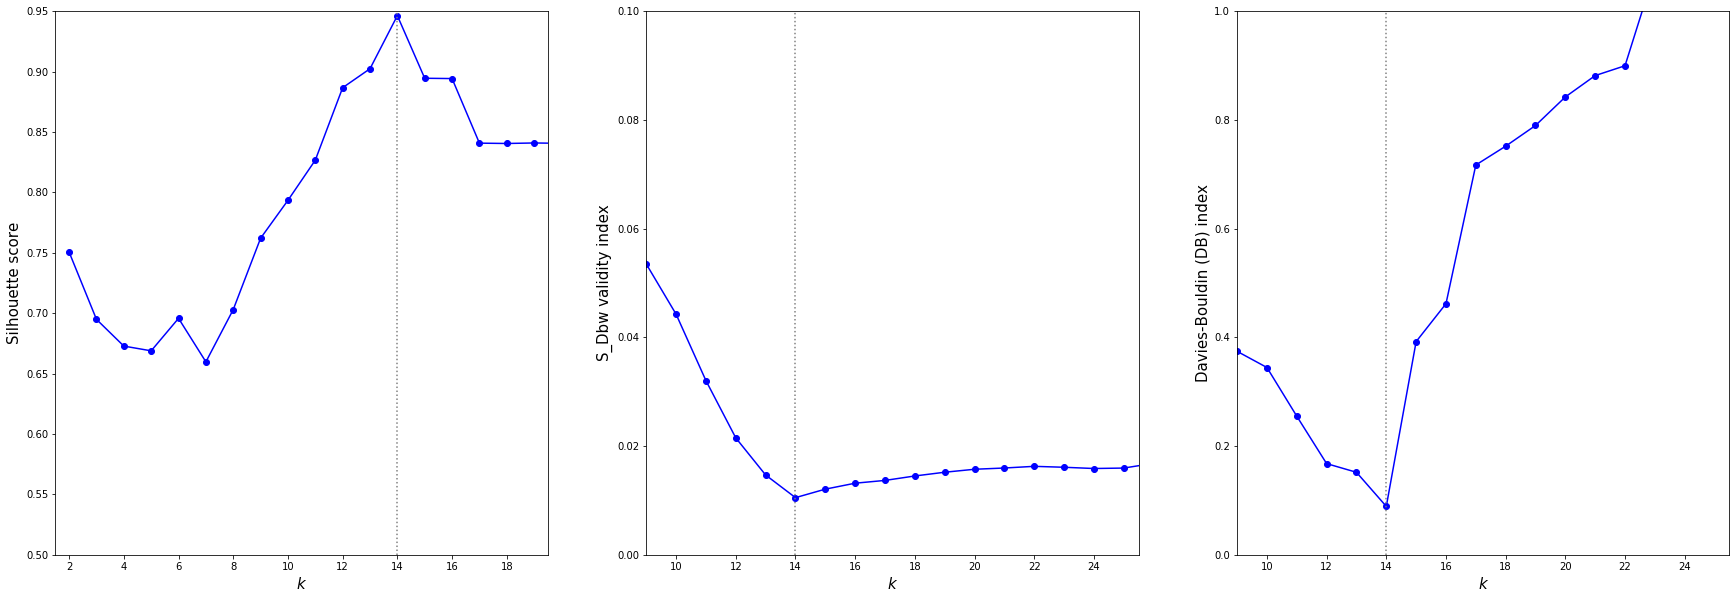

In [143]:
cluster_analysis(X.to_numpy(), 30)

**Subspace defined by the first 5 principal components of the standardized data**

In [144]:
pipeline = Pipeline([("std", StandardScaler()),
                     ("pca_std5d", PCA(n_components=5))])

In [145]:
X_std5d = pipeline.fit_transform(X)
X_std5d

array([[ 2.6822801 , -0.95101717, -0.19008332,  0.32119117,  0.72441773],
       [-2.94967459,  0.40158994,  1.04010164, -0.13470727,  0.07739643],
       [-2.32013202, -1.36869681, -0.48837924, -0.17324414, -0.02137966],
       ...,
       [-1.39443589,  1.09197838, -0.83126899,  0.26658712,  0.33698768],
       [ 3.20082365, -0.38116694,  0.29454421,  0.43994438,  0.35281943],
       [-2.71314751,  0.07725914,  0.05739812,  0.32509155, -0.03540578]])

The silhouette score is maximized at k = 14
The S_Dbw index is minimized at k = 14
The Davies-Bouldin (DB) index is minimized at k = 14


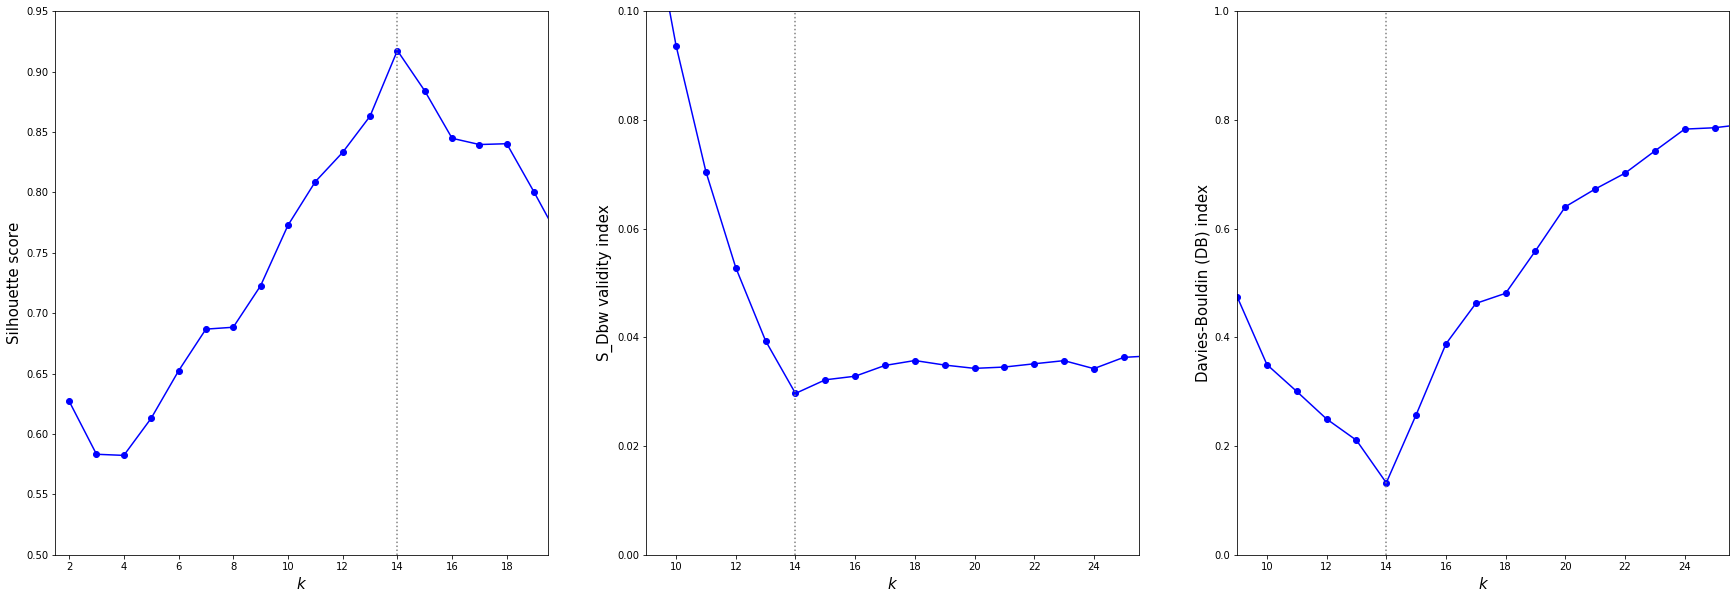

In [146]:
cluster_analysis(X_std5d, 30)

I notice that in these cases the analysis has the same outcome in terms of the best number of clusters, and it is easy to see that it also leads to the same exact optimal clustering (the labels of the clusters are shuffled, but the clusters are the same). Moreover, doing an explicit comparison of different preprocessings for example in terms of silhouette scores is in general not possible, since different feature dimensions lead to non-comparable silhouette scores.

## <a name="section4"></a>4. Data visualization on the first 2 and 3 principal components

Since, by looking at the graphs in [Section 2](#section2), the first 2 and the first 3 principal components preserve a very high proportion of the variance, meaning that 2D and 3D dimensionality reduction would not lose much information, it is reasonable to visualize the data and the clusters with 2D and 3D scatterplots. Thus, in this section, I plot the subspace defined by the first 2 principal components (2D scatterplot) and the subspace defined by the first three principal components (3D scatterplot) and highlight the clusterings according to the labels (cluster indices) found with the optimal number of clusters ($k$ = 14) in [Section 3](#section3), that are contained in `opt_kmeans.labels_`.

### <a name="section4.1"></a>4.1 Dimensionality reduction to 2D and clustering visualization with $k$ = 14

In [157]:
pca2d = PCA(n_components=2)
X_tr2d = pca2d.fit_transform(X_tr)

Text(0.5, 1.0, 'Clustered 2D reduced dataset with $k$ = 14')

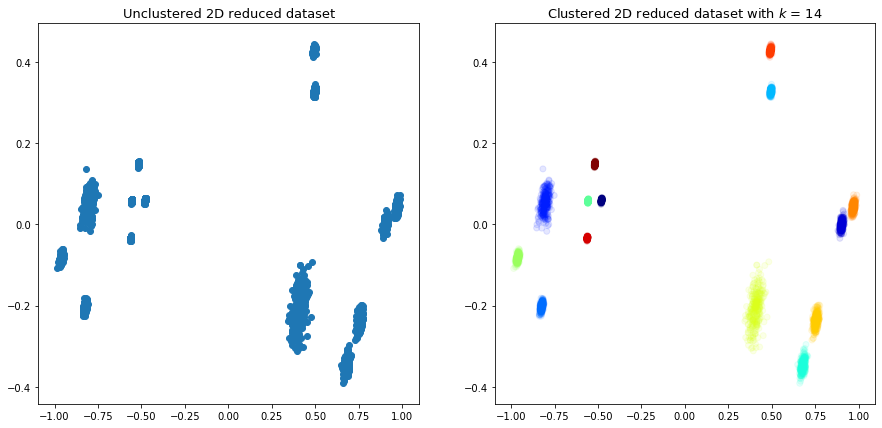

In [158]:
plt.figure(figsize=(15, 7))

plt.subplot(121)
plt.scatter(X_tr2d[:,0], X_tr2d[:,1])
plt.title("Unclustered 2D reduced dataset", fontsize=13)

plt.subplot(122)
plt.scatter(X_tr2d[:,0], X_tr2d[:,1], c=opt_kmeans.labels_, cmap="jet", alpha=0.1)
plt.title("Clustered 2D reduced dataset with $k$ = 14", fontsize=13)

### <a name="section4.2"></a>4.2 Dimensionality reduction to 3D and clustering visualization with $k$ = 14

In [159]:
pca3d = PCA(n_components=3)
X_tr3d = pca3d.fit_transform(X_tr)

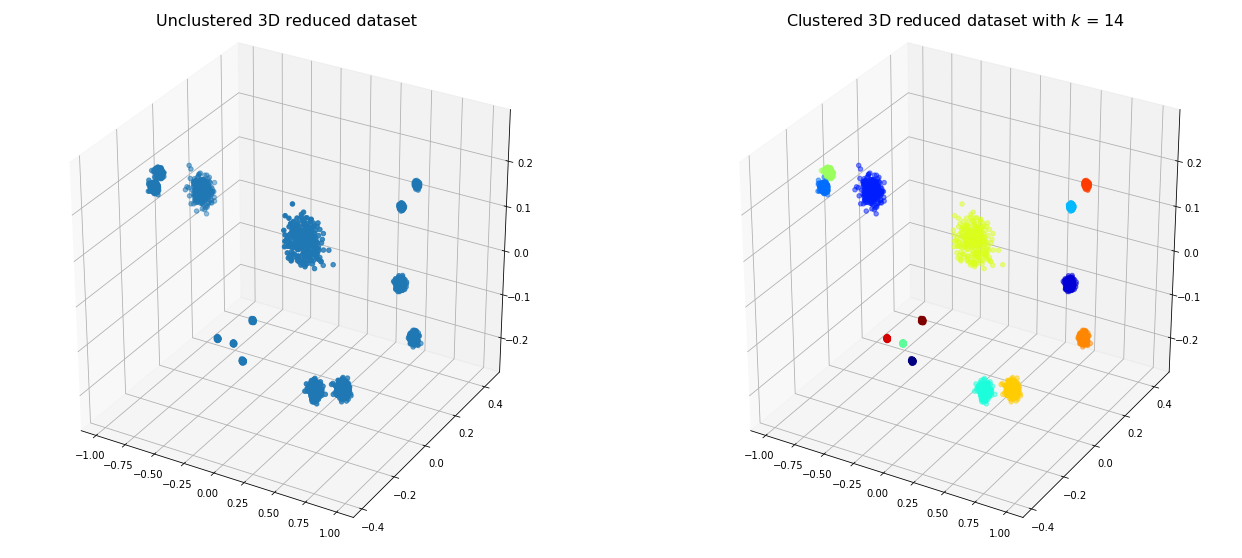

In [160]:
fig = plt.figure(figsize=(22, 10))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
p = ax1.scatter(X_tr3d[:,0], X_tr3d[:,1], X_tr3d[:,2])
plt.title("Unclustered 3D reduced dataset", fontsize=16, pad=25)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
p1 = ax2.scatter(X_tr3d[:,0], X_tr3d[:,1], X_tr3d[:,2], c=opt_kmeans.labels_, cmap="jet", alpha=0.5)
plt.title("Clustered 3D reduced dataset with $k$ = 14", fontsize=16, pad=25)

plt.show()

I notice that my results about the best number of clusters and the optimal clustering found are consistent with what I see in the above 2D and 3D scatterplots, in fact the plots clearly highlight the presence of 14 clusters. Moreover, I notice the presence of subclusters, meaning that the inter-cluster distance is very heterogeneous. Therefore, as already stated, this should have been the reason why in the *silhouette diagram* two knife shapes fell short of the red line representing the *silhouette score* (even though by not too much).

## <a name="section5"></a>5. Label print

In this section, I print in a .txt file the cluster label of each point found with the optimal number of clusters $k$ = 14 in [Section 3](#section3). This file is saved in the current working directory.

In [163]:
opt_labels = opt_kmeans.labels_

labels = [str(i) for i in opt_labels]
with open('K-Means_labels.txt', 'w') as w:
    w.write('\n'.join(labels))
w.close()

## <a name="section6"></a>6. Conclusions

To conclude, my analysis for finding the optimal clustering of the provided dataset proceeded as follows:
- I imported the dataset and performed a preliminary analysis, by looking at the raw data, obtaining a summary and computing some descriptive statistics about it, thereby understanding how to appropriately prepare the data to ensure that the algorithm would have run (e.g. I checked for the presence of missing values, that cannot be automatically handled by the K-Means algorithm) and that it would have performed well. This procedure included also data preprocessing, where, by looking at the descriptive statistics and histograms, I thought that scaling the data and discarding the 6-th principal component found by PCA would have most certainly helped for my analysis.
- I performed the core analysis, consisting of finding the best number of clusters, by using *internal clustering validation criteria*, since the data are unlabeled and therefore I had no external information about the clustering. All the applied criteria, i.e. *elbow method* with K-Means *inertia*, *silhouette analysis*, analysis with the *S_Dbw* index and analysis with the *Davies-Bouldin (DB)* index, led to the same answer, namely that $k$ = 14 is the best number of clusters. Thus, I stored the fitted optimal K-Means in a variable in order to save the optimal clustering. I want to point out that I also performed with some other different preprocessing techniques,   and the analysis had the same outcome in terms of the best number of clusters and led to the exact same clustering (the labels of the clusters were shuffled, but the clusters were the same).
- Since the first 2 and 3 components explained most of the variance, I plotted them to visualize the clustering (according to the labels found in the core analysis) and what I saw in the graphs was consistent with my findings. Moreover, I noticed the presence of subclusters, indicating that the inter-cluster distance was very heterogeneous.
- I printed the labels of the optimal clustering in a file as requested.